In [1]:
import numpy as np
import os

In [2]:
import scipy.spatial

In [3]:
stationlist=['NIG01','TDC01','TDC02','TDC03','TDC04','TDC05','TDC06','TDC07',\
             'TDC09','TDC10','TDC11','TDC12','TDC14','TDC15','TDC16','TDC19','TDC20',\
             'TDC22','TDC23','TDC26','TRIS']

In [4]:
from obspy.geodetics.base import gps2dist_azimuth

In [5]:
import matplotlib.pyplot as plt

In [6]:
def readlatlon(name):
    stfile= '../../maps/stations.dat'
    op= open(stfile, "r")
    line=op.readline()
    stname =line.split(' ')[3] 
    while(line!='' ): 
        stname =line.split(' ')[3]
        if (stname.split('\n')[0]==name):  
          stlon =float(line.split(" ")[0])
          stlat =float(line.split(" ")[1])
        line=op.readline()
    op.close() 
    return stlat,stlon


def findpath(st1,st2):
  import re
  #for the raypath
  pathfile='./raypath.out'
  opp=open(pathfile, "r")
  linep=opp.readline() #skip 1 line
  n1=stationlist.index(st1)
  n2=stationlist.index(st2)+1
  path=[]
  count=0
  while(count!=n1*21+n2):
    linep=opp.readline()
    if re.split(r'[\n\s]+',linep)[2]=='': 
        count+=1
        num=re.split(r'[\n\s]+',linep)[1]
    
  linep=opp.readline()
  while(re.split(r'[\n\s]+',linep)[2]!=''):
    
    stlon =float(re.split(r'[\n\s]+',linep)[2])
    stlat =float(re.split(r'[\n\s]+',linep)[1])
    path.append(np.array([stlon,stlat]))
    linep=opp.readline()      
  opp.close()
  return np.array(path), num

def bilinear_interpolation(x,y,x1,x2,y1,y2):
        # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation
        # order points by x, then by y
        
        if x1 > x2  or y1 > y2:
            raise ValueError('points do not form a rectangle')
        if not x1 <= x <= x2 or not y1 <= y <= y2:
            raise ValueError('(x, y) not within the rectangle')

        a00=(x2- x) * (y2 - y)/(x2 - x1) / (y2 - y1) + 0.0 
        a10=(x - x1) * (y2 - y)/(x2 - x1) / (y2 - y1) + 0.0 
        a01=(x2 - x) * (y - y1)/(x2 - x1) / (y2 - y1) + 0.0 
        a11=(x - x1) * (y - y1)/(x2 - x1) / (y2 - y1) + 0.0
        return  np.array([a00,a01,a10,a11])                  
                    


# try bamin 2001

In [7]:
def calmatrix(paths,vs,nums,x,y,xy,steps):
    tree = scipy.spatial.cKDTree(xy)
    #build G and d as same 
    v0=np.mean(vs)
    vs=np.array(vs)
    #v0=(max(vs)+min(vs))/2
    A=np.zeros((len(paths),len(x)*len(y)))
    b=np.zeros(len(paths))
    steps=np.zeros(len(paths))
    
    for n,p in enumerate(paths):
        _, column_idxs = tree.query(p,k=3)
        column_idxs2=np.zeros((len(column_idxs),4),dtype=int) #in case 4 points not a rectangle
        step,_ ,_ = gps2dist_azimuth(p[0][0],p[0][1],p[1][0],p[1][1])
        steps[n]=step/1000
        #column_idxs, counts = np.unique(column_idxs, return_counts=True)
        coef=np.zeros((len(p),4))
        for k,pi in enumerate(p):
            x0=pi[0]
            y0=pi[1]
            points=xy[np.sort(column_idxs[k])]
            (x1,x2,y1,y2)=(min(points.T[0]),max(points.T[0]),min(points.T[1]),max(points.T[1]))
            coef[k]=bilinear_interpolation(x0,y0,x1,x2,y1,y2)
            _, idxs1 = tree.query([x1,y1])
            _, idxs2 = tree.query([x1,y2])
            _, idxs3 = tree.query([x2,y1])
            _, idxs4 = tree.query([x2,y2])
            column_idxs2[k]=np.array([idxs1,idxs2,idxs3,idxs4],dtype=int)
        for j,indx in  enumerate(column_idxs2):
            A[n][indx] +=coef[j]
        b[n]=nums[n]/vs[n]*1
        A[n]=A[n]*steps[n]
    

    # dt vector
    step=np.mean(steps)
    G=A/v0
    b=b*steps
    #t0=np.matmul(A/v0,np.ones(len(x)*len(y)))
    t0=nums/v0*steps
    dt=b-t0

    # matrix Cinv
    Cinv = np.matrix(np.zeros((len(paths), len(paths))))
    np.fill_diagonal(Cinv,1.0)
    #Cinv =scipy.sparse.dia_matrix(np.diag(np.ones(len(dt))))
    #desity vector 
    #density =np.sum(A*v0/step, axis=0)
    density =np.zeros(len(xy))
    for a in A:
        for n,den in enumerate(density):
            if not a[n]==0:
                density[n]+=1
    #distance matrix
    dists = np.zeros((len(x)*len(y), len(x)*len(y)))
    for n,xyi in enumerate(xy):
        dists[n]=np.sum((xy-xyi)**2,axis=1)**0.5*111.11
    
    #build Q
    S = np.exp(- dists**2 / (2 * correlation_length**2))
    #S /= (S.sum(axis=-1) - np.diag(S))
    for n in range(0,len(S)):
        S[n] = S[n]/(S[n].sum(axis=-1)-1)
    #for n in range(0,len(S)):
    #    S[n] = S[n]/S[n].sum(axis=-1)
    # setting up spatial regularization matrix F
    F = np.matrix(-S)
    F[np.diag_indices_from(F)] = 1
    F *= alpha
    # setting up regularization matrix Q
    # ... Ft.F part
   
    Q = F.T * F
    # ... Ht.H part
    for i, path_density in enumerate(density):
        Q[i, i] += beta**2 * np.exp(-2 * lambda_ * path_density)

    #calculate best dv    
    covmopt = (G.T * Cinv * G + Q).I
    Ginv = covmopt * G.T
    mopt = Ginv * Cinv * (dt.reshape(len(dt),1))     
    mopt=np.array(mopt.T)[0]
    
    return mopt,v0

In [1115]:
def readfiles(direction,per):
    piarfile='./Good%s/stationpairs.dat'%direction
    opp=open(piarfile, "r")
    linep=opp.readline()
    paths=[]
    nums=[]
    vs=[]
    p=round(per,1)
    while(linep!='' ):
        phase_vel=np.loadtxt('./Good%s/'%direction+linep.split('_')[0]+'_'+linep.split('_')[1]+'_ph_smooth')
        if  phase_vel[phase_vel[:,0]==p].T[1].size==0 or np. isnan(phase_vel[phase_vel.T[0]==round(p,1)][0][1]):
            linep=opp.readline() 
            continue

        if float(phase_vel[phase_vel[:,0]==p].T[2]) <2.0:
            linep=opp.readline() 
            continue
            
        stat =[linep.split('_')[0],linep.split('_')[1]]
        path,num=findpath(stat[0],stat[1])
        
        stla1,stlo1= readlatlon(stat[0])
        stla2,stlo2= readlatlon(stat[1])
        dist,az,baz = gps2dist_azimuth(stla1,stlo1,
                              stla2,stlo2)
        if dist >400000:
            linep=opp.readline() 
            continue
        
        paths.append(path)
        nums.append(int(num))
        v=float(phase_vel[phase_vel[:,0]==p].T[1])
        vs.append(v)
        stla1,stlo1= readlatlon(stat[0])
        stla2,stlo2= readlatlon(stat[1])
        linep=opp.readline()     
    opp.close()
    return vs,nums,paths

In [1116]:
#loop auto

correlation_length=25
alpha=35
beta=100
lambda_=0.9

for size in [0.2]:
    outdir='./vel2D/size%s-3/'%size
    try:
        os.mkdir(outdir)
    except:
        print('exist')
    x=np.arange(-40,-35+0.1,size)
    y=np.arange(-16,-9+0.1,size)
    xg, yg = np.meshgrid(np.array(x),np.array(y))
    xy=np.c_[yg.T.ravel(),xg.T.ravel()]
    for direction in ['RR','TT']:
        for per in np.arange(3.5,7.6,0.1):

            vs,nums,paths=readfiles(direction,per)
            

            mopt,v0=calmatrix(paths,vs,nums,x,y,xy,steps)

            vopt=v0/(mopt+1)
            
            dvopt=1/(mopt+1)-1

            #save vel file
            fname='%s_%s.vel'%(direction,per)
            ops=open(outdir+'%s'%fname, "w")
            count=0
            for xi in x:
                for yi in y:
                    ops.write('%0.5f %0.5f %0.5f'%(yi,xi,vopt[count])+'\n')
                    count+=1       
            ops.close()


            #save dv file
            fname='%s_%ss.dv'%(direction,per)
            ops=open(outdir+'%s'%fname, "w")
            count=0
            for xi in x:
                for yi in y:
                    ops.write('%0.5f %0.5f %0.5f'%(yi,xi,(dvopt[count]*100))+'\n')
                    count+=1       
            ops.close()
                  
                  
            os.chdir("%s"%outdir)
            os.system('cp ../map* ./')
            os.system('cp ../*cpt ./')
             
            fname='%s_%s.vel'%(direction,per)
            os.system('./map.gmt ./%s %s %s'%(fname,size,size) )         
            fname='%s_%ss.dv'%(direction,per) 

            os.system('./mapdv.gmt %s %s %s'%(fname,size,size) )
            os.chdir("../../")
            

exist


# single 

In [741]:
#model define
x=np.arange(-40.0,-35+0.1,0.2)
y=np.arange(-16,-9+0.1,0.2)
xg, yg = np.meshgrid(np.array(x),np.array(y))
xy=np.c_[yg.T.ravel(),xg.T.ravel()]
tree = scipy.spatial.cKDTree(xy)


In [1171]:
direction='RR'
per=5.0
#find paths
piarfile='./Good%s/stationpairs.dat'%direction
opp=open(piarfile, "r")
linep=opp.readline()
paths=[]
nums=[]
vs=[]
p=round(per,1)
while(linep!='' ):
    phase_vel=np.loadtxt('./Good%s/'%direction+linep.split('_')[0]+'_'+linep.split('_')[1]+'_ph_smooth')
    if  phase_vel[phase_vel[:,0]==p].T[1].size==0 or np.isnan(phase_vel[phase_vel[:,0]==p].T[1]):
        linep=opp.readline() 
        continue
     
    stat =[linep.split('_')[0],linep.split('_')[1]]
    path,num=findpath(stat[0],stat[1])

    stla1,stlo1= readlatlon(stat[0])
    stla2,stlo2= readlatlon(stat[1])
    '''
    dist,az,baz = gps2dist_azimuth(stla1,stlo1,
                              stla2,stlo2)
    if dist >400000:
        linep=opp.readline() 
        print(stat)
        continue
    '''
    paths.append(path)
    nums.append(int(num))
    v=float(phase_vel[phase_vel[:,0]==p].T[1])
    vs.append(v)
    linep=opp.readline()     
opp.close()


17
['TDC01', 'TDC15']
['TDC01', 'TDC20']
['TDC01', 'TDC22']
['TDC01', 'TDC23']
['TDC02', 'TDC20']
['TDC02', 'TDC22']


In [76]:
#try to remove 10% outlier
num=len(vs)
idx1=int(0.05*num)
vmin=np.sort(vs)[idx1]
vmax=np.sort(vs)[-idx1]
#vmax=5.0
paths=np.array(paths)[(vs<vmax)&(vs>vmin)]
nums=np.array(nums)[(vs<vmax)&(vs>vmin)]
vs=np.array(vs)[(vs<vmax)&(vs>vmin)]

/home/gphs1/hzhang/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


In [1178]:
correlation_length=25
alpha=35
beta=100
lambda_=0.9
#build G and d as same 
v0=np.mean(vs)
vs=np.array(vs)
#v0=(max(vs)+min(vs))/2
A=np.zeros((len(paths),len(x)*len(y)))
b=np.zeros(len(paths))
steps=np.zeros(len(paths))
for n,p in enumerate(paths):
    _, column_idxs = tree.query(p,k=3)
    column_idxs2=np.zeros((len(column_idxs),4),dtype=int) #in case 4 points not a rectangle
    step,_ ,_ = gps2dist_azimuth(p[0][0],p[0][1],p[1][0],p[1][1])
    steps[n]=step/1000
    #column_idxs, counts = np.unique(column_idxs, return_counts=True)
    coef=np.zeros((len(p),4))
    for k,pi in enumerate(p):
        x0=pi[0]
        y0=pi[1]
        points=xy[np.sort(column_idxs[k])]
        (x1,x2,y1,y2)=(min(points.T[0]),max(points.T[0]),min(points.T[1]),max(points.T[1]))
        coef[k]=bilinear_interpolation(x0,y0,x1,x2,y1,y2)
        _, idxs1 = tree.query([x1,y1])
        _, idxs2 = tree.query([x1,y2])
        _, idxs3 = tree.query([x2,y1])
        _, idxs4 = tree.query([x2,y2])
        column_idxs2[k]=np.array([idxs1,idxs2,idxs3,idxs4],dtype=int)
    for j,indx in  enumerate(column_idxs2):
        A[n][indx] +=coef[j]
    b[n]=nums[n]/vs[n]*1
    A[n]=A[n]*steps[n]
    


# dt vector
step=np.mean(steps)
G=A/v0
b=b*steps 
#t0=np.matmul(A/v0,np.ones(len(x)*len(y)))
t0=nums/v0*steps
dt=b-t0
'''
#make checkboard model
step=np.mean(steps)
G=A/v0
b=b*steps
vc=np.ones(len(x)*len(y))
count=0
for n,xi in enumerate(x):
    v1=0.2*v0*(-1)**(int((n)/5)+1)
    for m,yi in enumerate(y):
        vc[count]=v0-v1*(-1)**(int((m)/5)+1)
        count+=1
tc=np.matmul(G*v0,1/vc)        
t0=nums/v0*steps
dt=tc-t0
#noise = np.random.normal(-0.05*v0, 0.05*v0, dt.shape)
#dt=dt+noise
'''
# matrix Cinv
Cinv = np.matrix(np.zeros((len(paths), len(paths))))
np.fill_diagonal(Cinv,1.0)
#Cinv =scipy.sparse.dia_matrix(np.diag(np.ones(len(dt))))
#desity vector 
#density =np.sum(A*v0/step, axis=0)
density =np.zeros(len(xy))
for a in A:
    for n,den in enumerate(density):
        if not a[n]==0:
            density[n]+=1
#distance matrix
dists = np.zeros((len(x)*len(y), len(x)*len(y)))
for n,xyi in enumerate(xy):
    dists[n]=np.sum((xy-xyi)**2,axis=1)**0.5*111.11

#build Q
S = np.exp(- dists**2 / (2 * correlation_length**2))
#S /= (S.sum(axis=-1) - np.diag(S))
for n in range(0,len(S)):
    S[n] = S[n]/(S[n].sum(axis=-1)-1)
#for n in range(0,len(S)):
#    S[n] = S[n]/S[n].sum(axis=-1)
# setting up spatial regularization matrix F
F = np.matrix(-S)
F[np.diag_indices_from(F)] = 1
F *= alpha

# setting up regularization matrix Q
# ... Ft.F part
Q = F.T * F
# ... Ht.H part
for i, path_density in enumerate(density):
    Q[i, i] += beta**2 * np.exp(-2 * lambda_ * path_density)
#calculate best dv    
covmopt = (G.T * Cinv * G + Q).I
Ginv = covmopt * G.T
mopt = Ginv * Cinv * (dt.reshape(len(dt),1))    
'''
Q=F
for i, path_density in enumerate(density):
    Q[i, i] += beta**1 * np.exp(-1 * lambda_ * path_density)

#dv=(np.matmul(G.T , G) +np.matmul(H.T , H) ).I*G.T*(dt.reshape(len(dt),1))  
covmopt = (G.T * Cinv * G + Q.T*Q ).I
Ginv = covmopt * G.T
mopt = Ginv * Cinv * (dt.reshape(len(dt),1))    
'''


'\nQ=F\nfor i, path_density in enumerate(density):\n    Q[i, i] += beta**1 * np.exp(-1 * lambda_ * path_density)\n\n#dv=(np.matmul(G.T , G) +np.matmul(H.T , H) ).I*G.T*(dt.reshape(len(dt),1))  \ncovmopt = (G.T * Cinv * G + Q.T*Q ).I\nGinv = covmopt * G.T\nmopt = Ginv * Cinv * (dt.reshape(len(dt),1))    \n'

/home/gphs1/hzhang/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


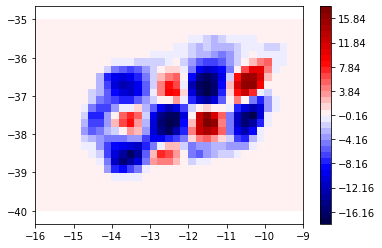

In [1137]:
import matplotlib as mpl
cmap = plt.get_cmap('seismic')
zmin=np.round(min(1/(mopt+(1))-1)*100,2)
zmax=np.round(max(1/(mopt+(1))-1)*100,2)
bounds = np.arange(zmin,-zmin,1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
plt.pcolormesh(y,x,100*(1/(mopt+(1))-1).reshape(len(x),len(y)),cmap=cmap,norm=norm)
plt.axis('equal')
#plt.clim(3.2,4.0)
plt.colorbar(orientation='vertical')
plt.show()

/home/gphs1/hzhang/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


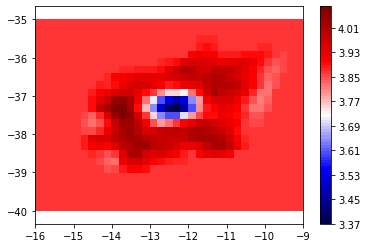

In [1022]:
import matplotlib as mpl
cmap = plt.get_cmap('seismic')
zmin=np.round(min(v0/(mopt+(1))),2)
zmax=np.round(max(v0/(mopt+(1))),2)
bounds = np.arange(zmin,zmax,0.01)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
plt.pcolormesh(y,x,(v0/(mopt+(1))).reshape(len(x),len(y)),cmap=cmap,norm=norm)
plt.axis('equal')
#plt.clim(3.2,4.0)
plt.colorbar(orientation='vertical')
plt.show()

/home/gphs1/hzhang/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


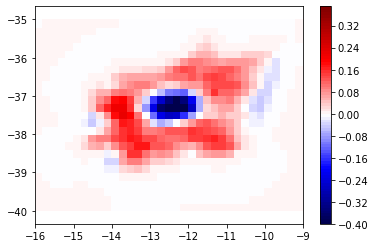

In [1021]:
import matplotlib as mpl
cmap = plt.get_cmap('seismic')
zmin=int(min(v0/(mopt+(1))-v0)/0.1)*0.1
zmax=int(max(v0/(mopt+(1))-v0)/0.1)*0.1
bounds = np.arange(zmin,-zmin,0.01)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
plt.pcolormesh(y,x,(v0/(mopt+(1))-v0).reshape(len(x),len(y)),cmap=cmap,norm=norm)
plt.axis('equal')
#plt.clim(3.2,4.0)
plt.colorbar(orientation='vertical')
plt.show()

/home/gphs1/hzhang/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


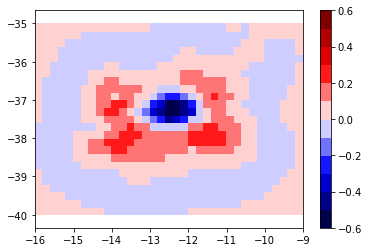

In [965]:
import matplotlib as mpl
cmap = plt.get_cmap('seismic')
zmin=int(min(v0/(mopt+(1))-v0)/0.1)*0.1
zmax=int(max(v0/(mopt+(1))-v0)/0.1)*0.1
bounds = np.arange(zmin,-zmin,0.1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
plt.pcolormesh(y,x,(v0/(mopt+(1))-v0).reshape(len(x),len(y)),cmap=cmap,norm=norm)
plt.axis('equal')
#plt.clim(3.2,4.0)
plt.colorbar(orientation='vertical')
plt.show()

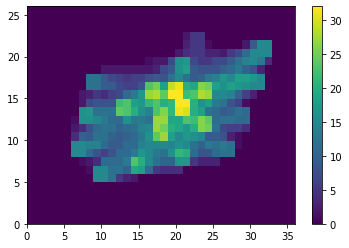

In [312]:
#plt.pcolormesh(S/(S.sum(axis=-1)- np.diag(S)))
#plt.plot(np.array(S[0,1::]))
plt.pcolormesh(density.reshape(len(x),len(y)))
#plt.pcolormesh(S)
plt.colorbar(orientation='vertical')

In [1180]:
#resolution 
R = Ginv * Cinv * G

In [334]:
from scipy.optimize import curve_fit

In [1181]:
        Rradius = np.zeros(len(xy))
        heights = np.zeros(len(xy))
        max_amp=np.max(R)
        for i, Ri in enumerate(np.array(R)):
            lon0, lat0 = xy[i]
            if Ri.max()<0.2*max_amp:
                continue
            # best-fitting cone at point (lon0, lat0)

            # Function returning the height of cone of radius *r0*
            # and peak *z0*, at a point located *r* km away from
            # the cone's center
            '''
            if resolution_fit.lower().strip() == 'cone':
                def cone_height(r, z0, r0):
                    """
                    Cone
                    """
                    return np.where(r < r0, z0 * (1 - r / r0), 0.0)
            elif resolution_fit.lower().strip() == 'gaussian':
                def cone_height(r, z0, r0):
                    """
                    Gaussian function
                    """
                    sigma = r0 / 2.0
                    return z0 * np.exp(- r**2 / (2 * sigma**2))
            else:
                s = "Unknown function to fit resolution: '{}'"
                raise Exception(s.format(resolution_fit))
            ''' 
            def cone_height(r, z0, r0):
                return np.where(r < r0, z0 * (1 - r / r0), 0.0)
            '''            
            def cone_height(r, z0, r0):
                sigma = r0 / 2.0
                return z0 * np.exp(- r**2 / (2 * sigma**2))
            ''' 
            # distances between nodes and cone's center (lon0, lat0)
            rdata=np.sum((xy-xy[i])**2,axis=1)**0.5*111.11
            # best possible resolution *rmin* = 2 * inter-node distance
            # -> estimating *rmin* along the meridian crossing the cone's
            #    center (conservative choice as it yields the largest
            #    possible value)
            d2rad = np.pi / 180.0
            rmin = 2 * d2rad * 6371.0 * max(0.2 * np.cos(lat0 * d2rad),0.2)
            #rmin=0.2*111.11*2
            # fitting the above function to observed heights along nodes,
            # in array abs(Ri)
            popt, _ = curve_fit(f=cone_height, xdata=rdata[Ri>0.05*max(Ri)], ydata=np.abs(Ri[Ri>0.05*max(Ri)]),
                                p0=[1, 2*rmin], maxfev=1000)
            z0, r0 = popt

            # reslution cannot be better than *rmin*
            r0 = max(rmin, r0)

            # appending spatial resolution to array
            Rradius[i] = r0
            heights[i] = z0
        #Rradius[Rradius>250.0] = 0.0
        Rradius[Rradius==0.0] = np.nan
       

In [815]:
rdata=np.sum((xy-xy[520])**2,axis=1)**0.5*111.11

popt, _=curve_fit(f=cone_height, xdata=rdata[Ri>0.*max(Ri)], ydata=np.abs(Ri[Ri>0.1*max(Ri)]),
                                p0=[1, 2*rmin], maxfev=1000)

In [649]:
import numpy as np
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

In [742]:
Rradius = np.zeros(len(xy))
max_amp=np.max(R)
for i, Ri in enumerate(np.array(R)):
    if Ri.max()<0.2*max_amp:
        continue
    Ri=np.array(Ri).flatten()
    xys=xy[Ri>=0.1*max(Ri)]

    ell = EllipseModel()
    ell.estimate(xys)

    xc, yc, a, b, theta = ell.params
    Rradius[i]=b*2*111.11
Rradius[Rradius==0.0] = np.nan